In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pathlib

from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer

from src.utils.transform import (HourExtractor, WeekendExtractor, 
    FringeCategoryBucketer, OutlierRemover)

from src.utils.evaluation import evaluate

In [3]:
cfg = OmegaConf.load('../config.yaml')

In [4]:
processed_data_dir = '..' / pathlib.Path(cfg.paths.data.processed)
processed_file = processed_data_dir / cfg.files.processed_dataset

df = pd.read_csv(processed_file)

## Train Test Split

In [5]:
X = df.copy()
y = X.pop(cfg.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, random_state=42)

## Basic Logreg

In [6]:
# Simple preprocessing
numeric_transformer = make_pipeline(
    OutlierRemover(), SimpleImputer(strategy='median'), StandardScaler()
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerics', numeric_transformer, ['download_mbit', 'upload_mbit', 'ping_ms'])
    ]
)

pipe = Pipeline([
    ('prep', preprocessor),
    ('logreg', LogisticRegression())
])

In [7]:
pipe

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerics',
                                                  Pipeline(steps=[('outlierremover',
                                                                   OutlierRemover()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['download_mbit',
                                                   'upload_mbit',
                                                   'ping_ms'])])),
                ('logreg', LogisticRegression())])

In [8]:
# Hyperparameters for training
param_grid = {
    'prep__numerics__outlierremover__upper_threshold_factor': range(2, 5),
    'logreg__C': [10**(i) for i in np.arange(-2, 3, 1, dtype=float)],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__class_weight': ['balanced', None],
    'logreg__solver': ['liblinear'],
    'logreg__max_iter': [200]
}

In [9]:
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=True
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numerics',
                                                                         Pipeline(steps=[('outlierremover',
                                                                                          OutlierRemover()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['download_mbit',
                                                                          'upload_mbit',
                   

In [10]:
grid.best_params_

{'logreg__C': 10.0,
 'logreg__class_weight': 'balanced',
 'logreg__max_iter': 200,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear',
 'prep__numerics__outlierremover__upper_threshold_factor': 2}

In [11]:
y_test_pred = grid.best_estimator_.predict(X_test)

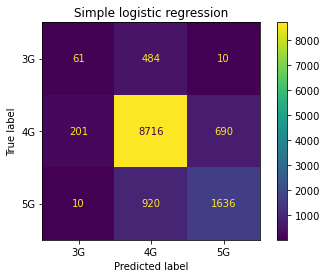

              precision    recall  f1-score   support

          3G       0.22      0.11      0.15       555
          4G       0.86      0.91      0.88      9607
          5G       0.70      0.64      0.67      2566

    accuracy                           0.82     12728
   macro avg       0.60      0.55      0.57     12728
weighted avg       0.80      0.82      0.81     12728

AVG PRECISION: 0.595 (macro)
AVG RECALL: 0.552 (macro)
AVG F1: 0.566 (macro)


In [12]:
evaluate(y_test, y_test_pred, title='Simple logistic regression', average='macro')

## Advanced logistic regression

In [13]:
# Full transformer pipeline
numeric_transformer = make_pipeline(
    OutlierRemover(), 
    SimpleImputer(strategy='median'), StandardScaler()
)

categorical_transformer = make_pipeline(
    FringeCategoryBucketer(), OneHotEncoder(handle_unknown='ignore')
)

weekend_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'), WeekendExtractor()
) 

hour_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'), HourExtractor()
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerics', numeric_transformer, list(cfg.inputs.numerics)),
        ('categories', categorical_transformer, list(cfg.inputs.categories)),
        ('weekend', weekend_transformer, list(cfg.inputs.datetimes)),
        ('hour', hour_transformer, list(cfg.inputs.datetimes)),
    ]
)

pipe = Pipeline([
    ('prep', preprocessor),
    ('logreg', LogisticRegression())
])

In [14]:
pipe

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerics',
                                                  Pipeline(steps=[('outlierremover',
                                                                   OutlierRemover()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'long',
                                                   'download_mbit',
                                                   'upload_mbit', 'ping_ms',
                                                   'lte_rsrp',
                                                   'signal_strength']),
                                     

In [15]:
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=True
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numerics',
                                                                         Pipeline(steps=[('outlierremover',
                                                                                          OutlierRemover()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['lat',
                                                                          'long',
                                    

In [16]:
grid.best_params_

{'logreg__C': 10.0,
 'logreg__class_weight': 'balanced',
 'logreg__max_iter': 200,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear',
 'prep__numerics__outlierremover__upper_threshold_factor': 3}

In [17]:
y_test_pred = grid.best_estimator_.predict(X_test)

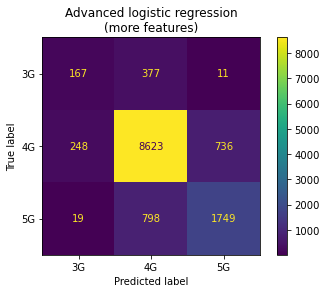

              precision    recall  f1-score   support

          3G       0.38      0.30      0.34       555
          4G       0.88      0.90      0.89      9607
          5G       0.70      0.68      0.69      2566

    accuracy                           0.83     12728
   macro avg       0.66      0.63      0.64     12728
weighted avg       0.82      0.83      0.82     12728

AVG PRECISION: 0.655 (macro)
AVG RECALL: 0.627 (macro)
AVG F1: 0.639 (macro)


In [18]:
evaluate(y_test, y_test_pred, title='Advanced logistic regression\n(more features)', average='macro')

## LightGBM Model

In [19]:
# TODO
# sklearn interface
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html